In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
import gym
from gym import spaces
import gym_dynamic_set_packing
import time

## training loop code

below is the code for the training loop. after that are definitions of two simple agents.

In [3]:
def train_loop(env, agent, episode_count, batches_per_episode, max_steps, quiet=False):
    done = False
    ep_rewards = []
    for i in tqdm(range(episode_count)):
        reward = 0.0
        if not quiet:
            print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for batch_idx in range(batches_per_episode):
            curr_obs = []
            curr_act = []
            curr_reward = []
            for i in range(max_steps):
                curr_obs.append(ob)
                action = agent.act(ob, reward, done)
                curr_act.append(action)
                ob, reward, done, _ = env.step(action)
                curr_reward.append(reward)
                if not quiet:
                    print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
            history_dict['observations'].append(np.stack(curr_obs,axis=0))
            history_dict['actions'].append(curr_act)
            history_dict['rewards'].append(curr_reward)
        total_reward = np.sum(history_dict['rewards']) / batches_per_episode
        agent.learn(history_dict)
        history_dict = None
        if not quiet:
            print('total episode reward: {}'.format(total_reward))
        ep_rewards.append(total_reward)
    return ep_rewards

## agents

In [4]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = torch.distributions.Categorical(torch.tensor([match_prob, 1 - match_prob], dtype=torch.float32))
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.item()
    
    def learn(self, history_dict):
        pass

In [5]:
def discounted_episode_returns(rewards, gamma=0.99):
    """
    Given a sequence of rewards, returns the sequence
    of the discounted returns (G_t) at each time step,
    with discount rate gamma (default 0.999).
    """
    # thanks to yuhao for writing this code for another project
    length = len(rewards)
    discounts = [gamma**x for x in range(length)]
    result = [np.dot(discounts[:length-i], rewards[i:]) for i in range(length)]
    return np.array(result, dtype='float32')

In [6]:
def pg_target(policy_dist, rewards, action_trajectory):
    """
    The policy gradient target loss (without baseline). Note it should be negative because
    optimizers minimize by default. Rewards should be cumulative and discounted.
    All inputs should already be tensors, not lists or np arrays.
    """
    return -torch.mean(policy_dist.log_prob(action_trajectory)*rewards)

In [8]:
def pg_baseline_target(policy_dist, delta, action_trajectory):
    """
    The policy gradient target loss (with baseline). Note it should be negative because
    optimizers minimize by default. delta should be discounted rewards minus value estimates. 
    All inputs should already be tensors, not lists or np arrays.
    """
    return -torch.mean(policy_dist.log_prob(action_trajectory)*delta)

In [11]:
class MLPMatchAgent:
    def __init__(self, observation_shape, gamma=0.99, gpu=False):
        self.action_space = spaces.Discrete(2)
        
        self.policy_net = nn.Sequential(
            nn.Linear(observation_shape, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32,2)
        )
        self.value_net = nn.Sequential(
            nn.Linear(observation_shape, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

        self.gpu = gpu
        if gpu:
            self.policy_net.cuda()
            self.value_net.cuda()
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        self.optimizer = torch.optim.Adam(list(self.policy_net.parameters()) + list(self.value_net.parameters()))
        self.gamma = gamma
    
    def policy(self, observation_batch):
        return torch.distributions.Categorical(logits=self.policy_net(observation_batch))
    
    def value(self, observation_batch):
        return self.value_net(observation_batch)
    
    def act(self, observation, reward, done):
        "Act on a single observation, return an action."
        observation_as_batch = torch.tensor(np.expand_dims(observation, 0), dtype=torch.float32, requires_grad=False, device=self.device)
        action_sample = self.policy(observation_as_batch).sample().detach().cpu().numpy()
        return action_sample[0]
    
    def learn(self, history_dict):
        """
        Perform the policy gradient update with its optimizer and policy.
        
        history_dict in general contains batches of episodes; we flatten these out
        into one enormous batch (as long as discounting of rewards is done correctly, the policy gradient loss
        doesn't care where each example came from).
        """
        
        # discounted returns, flattened out
        disc_returns = torch.as_tensor(np.concatenate([discounted_episode_returns(r, gamma=self.gamma) for r in history_dict['rewards']]), dtype=torch.float32, device=self.device)
        observations_tensor = torch.as_tensor(np.vstack(history_dict['observations']), dtype=torch.float32, device=self.device)
        actions_tensor = torch.as_tensor(np.concatenate(history_dict['actions']), dtype=torch.float32, device=self.device)
        
        self.optimizer.zero_grad()
        policy_dists = self.policy(observations_tensor)
        value_estimates = self.value(observations_tensor)
        delta = disc_returns - value_estimates
        value_loss = delta.mean() # delta.pow(2) instead?
        
        policy_loss = pg_target(policy_dists,
                             delta,
                             actions_tensor)
        torch.autograd.backward([value_loss, policy_loss])
        self.optimizer.step()

history dict consists of:

B x obs_dim x episode_length

returns consists of

B x episode length

actions consists of

B x episode length

we want to apply discounted_episode_returns to each 1 x episode_length return sequence

then it should be safe to flatten and concatenate all these, and make one update with the pg loss

## blood types example (fast, testing)

In [12]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = MLPMatchAgent(env_example.observation_space.shape[0], gamma=0.999)
ep_rewards = train_loop(env_example, ag, 100, 4, 10, quiet=True)

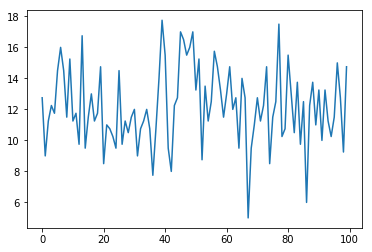

In [13]:
plt.plot(ep_rewards)

## blood types example (long)

In [55]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = MLPMatchAgent(env_example.observation_space.shape[0], gamma=0.999, gpu=True)
ep_rewards = train_loop(env_example, ag, 100, 32, 50, quiet=True)

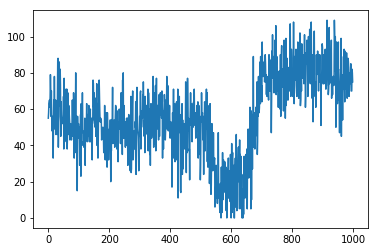

In [56]:
plt.plot(ep_rewards)

compare to random agent

In [60]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = RandomMatchAgent(0.5)
random_ep_rewards = train_loop(env_example, ag, 1000, 50, quiet=True)

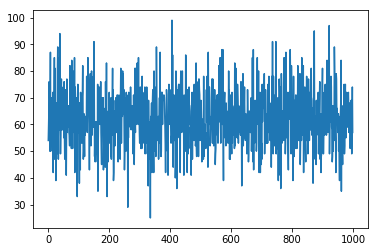

In [61]:
plt.plot(random_ep_rewards)

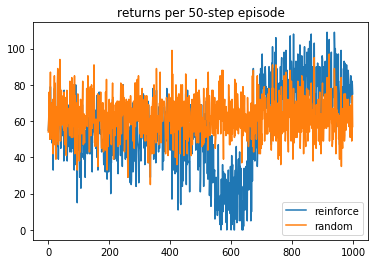

In [70]:
plt.plot(ep_rewards, label='reinforce')
plt.plot(random_ep_rewards, label='random')
plt.title('returns per 50-step episode')
plt.legend()
plt.savefig('returns_plot.png')
plt.show()
